In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from __future__ import print_function
import numpy as np
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,10)
figsize=(18, 10)

In [2]:
import base64
import datetime
import hashlib
import hmac
import json
import urllib
import urllib.parse
import urllib.request
import requests

# 此处填写APIKEY

ACCESS_KEY = "fb5335bd-b1902e32-cc0b36e2-6850a"
SECRET_KEY = "49761a11-c8c3b8d3-e3639666-6a6c4"



# API 请求地址
MARKET_URL = "https://api.huobi.pro"
TRADE_URL = "https://api.huobi.pro"

# 首次运行可通过get_accounts()获取acct_id,然后直接赋值,减少重复获取。
ACCOUNT_ID = None

#'Timestamp': '2017-06-02T06:13:49'

def http_get_request(url, params, add_to_headers=None):
    headers = {
        "Content-type": "application/x-www-form-urlencoded",
        'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.71 Safari/537.36',
    }
    if add_to_headers:
        headers.update(add_to_headers)
    postdata = urllib.parse.urlencode(params)
    response = requests.get(url, postdata, headers=headers, timeout=10) 
    try:
        
        if response.status_code == 200:
            return response.json()
        else:
            return
    except BaseException as e:
        print("httpGet failed, detail is:%s,%s" %(response.text,e))
        return


def http_post_request(url, params, add_to_headers=None):
    headers = {
        "Accept": "application/json",
        'Content-Type': 'application/json'
    }
    if add_to_headers:
        headers.update(add_to_headers)
    postdata = json.dumps(params)
    response = requests.post(url, postdata, headers=headers, timeout=10)
    try:
        
        if response.status_code == 200:
            return response.json()
        else:
            return
    except BaseException as e:
        print("httpPost failed, detail is:%s,%s" %(response.text,e))
        return


def api_key_get(params, request_path):
    method = 'GET'
    timestamp = datetime.datetime.utcnow().strftime('%Y-%m-%dT%H:%M:%S')
    params.update({'AccessKeyId': ACCESS_KEY,
                   'SignatureMethod': 'HmacSHA256',
                   'SignatureVersion': '2',
                   'Timestamp': timestamp})

    host_url = TRADE_URL
    host_name = urllib.parse.urlparse(host_url).hostname
    host_name = host_name.lower()
    params['Signature'] = createSign(params, method, host_name, request_path, SECRET_KEY)

    url = host_url + request_path
    return http_get_request(url, params)


def api_key_post(params, request_path):
    method = 'POST'
    timestamp = datetime.datetime.utcnow().strftime('%Y-%m-%dT%H:%M:%S')
    params_to_sign = {'AccessKeyId': ACCESS_KEY,
                      'SignatureMethod': 'HmacSHA256',
                      'SignatureVersion': '2',
                      'Timestamp': timestamp}

    host_url = TRADE_URL
    host_name = urllib.parse.urlparse(host_url).hostname
    host_name = host_name.lower()
    params_to_sign['Signature'] = createSign(params_to_sign, method, host_name, request_path, SECRET_KEY)
    url = host_url + request_path + '?' + urllib.parse.urlencode(params_to_sign)
    return http_post_request(url, params)


def createSign(pParams, method, host_url, request_path, secret_key):
    sorted_params = sorted(pParams.items(), key=lambda d: d[0], reverse=False)
    encode_params = urllib.parse.urlencode(sorted_params)
    payload = [method, host_url, request_path, encode_params]
    payload = '\n'.join(payload)
    payload = payload.encode(encoding='UTF8')
    secret_key = secret_key.encode(encoding='UTF8')

    digest = hmac.new(secret_key, payload, digestmod=hashlib.sha256).digest()
    signature = base64.b64encode(digest)
    signature = signature.decode()
    return signature

In [3]:
'''
Market data API
'''


# 获取KLine
def get_kline(symbol, period, size=150):
    """
    :param symbol
    :param period: 可选值：{1min, 5min, 15min, 30min, 60min, 1day, 1mon, 1week, 1year }
    :param size: 可选值： [1,2000]
    :return:
    """
    params = {'symbol': symbol,
              'period': period,
              'size': size}

    url = MARKET_URL + '/market/history/kline'
    return http_get_request(url, params)

def get_kline_df(symbol, period, size=150):
    res = get_kline(symbol, period, size)
    df = pd.DataFrame(res['data'])
    df = df.set_index(keys=['id'])
    df.index = pd.to_datetime(df.index, unit='s')
    return df

# 获取marketdepth
def get_depth(symbol, type):
    """
    :param symbol
    :param type: 可选值：{ percent10, step0, step1, step2, step3, step4, step5 }
    :return:
    """
    params = {'symbol': symbol,
              'type': type}
    
    url = MARKET_URL + '/market/depth'
    return http_get_request(url, params)


# 获取tradedetail
def get_trade(symbol):
    """
    :param symbol
    :return:
    """
    params = {'symbol': symbol}

    url = MARKET_URL + '/market/trade'
    return http_get_request(url, params)


# 获取merge ticker
def get_ticker(symbol):
    """
    :param symbol: 
    :return:
    """
    params = {'symbol': symbol}

    url = MARKET_URL + '/market/detail/merged'
    return http_get_request(url, params)


# 获取 Market Detail 24小时成交量数据
def get_detail(symbol):
    """
    :param symbol
    :return:
    """
    params = {'symbol': symbol}

    url = MARKET_URL + '/market/detail'
    return http_get_request(url, params)

# 获取  支持的交易对
def get_symbols(long_polling=None):
    """
    """
    params = {}
    if long_polling:
        params['long-polling'] = long_polling
    path = '/v1/common/symbols'
    return api_key_get(params, path)

'''
Trade/Account API
'''


def get_accounts():
    """
    :return: 
    """
    path = "/v1/account/accounts"
    params = {}
    return api_key_get(params, path)

ACCOUNT_ID = 0
# 获取当前账户资产
def get_balance(acct_id=None):
    """
    :param acct_id
    :return:
    """
    global ACCOUNT_ID
    
    if not acct_id:
        accounts = get_accounts()
        acct_id = accounts['data'][0]['id'];

    url = "/v1/account/accounts/{0}/balance".format(acct_id)
    params = {"account-id": acct_id}
    return api_key_get(params, url)


# 下单

# 创建并执行订单
def send_order(amount, source, symbol, _type, price=0):
    """
    :param amount: 
    :param source: 如果使用借贷资产交易，请在下单接口,请求参数source中填写'margin-api'
    :param symbol: 
    :param _type: 可选值 {buy-market：市价买, sell-market：市价卖, buy-limit：限价买, sell-limit：限价卖}
    :param price: 
    :return: 
    """
    try:
        accounts = get_accounts()
        acct_id = accounts['data'][0]['id']
    except BaseException as e:
        print ('get acct_id error.%s' % e)
        acct_id = ACCOUNT_ID

    params = {"account-id": acct_id,
              "amount": amount,
              "symbol": symbol,
              "type": _type,
              "source": source}
    if price:
        params["price"] = price

    url = '/v1/order/orders/place'
    return api_key_post(params, url)


# 撤销订单
def cancel_order(order_id):
    """
    
    :param order_id: 
    :return: 
    """
    params = {}
    url = "/v1/order/orders/{0}/submitcancel".format(order_id)
    return api_key_post(params, url)


# 查询某个订单
def order_info(order_id):
    """
    
    :param order_id: 
    :return: 
    """
    params = {}
    url = "/v1/order/orders/{0}".format(order_id)
    return api_key_get(params, url)


# 查询某个订单的成交明细
def order_matchresults(order_id):
    """
    
    :param order_id: 
    :return: 
    """
    params = {}
    url = "/v1/order/orders/{0}/matchresults".format(order_id)
    return api_key_get(params, url)


# 查询当前委托、历史委托
def orders_list(symbol, states, types=None, start_date=None, end_date=None, _from=None, direct=None, size=None):
    """
    
    :param symbol: 
    :param states: 可选值 {pre-submitted 准备提交, submitted 已提交, partial-filled 部分成交, partial-canceled 部分成交撤销, filled 完全成交, canceled 已撤销}
    :param types: 可选值 {buy-market：市价买, sell-market：市价卖, buy-limit：限价买, sell-limit：限价卖}
    :param start_date: 
    :param end_date: 
    :param _from: 
    :param direct: 可选值{prev 向前，next 向后}
    :param size: 
    :return: 
    """
    params = {'symbol': symbol,
              'states': states}

    if types:
        params[types] = types
    if start_date:
        params['start-date'] = start_date
    if end_date:
        params['end-date'] = end_date
    if _from:
        params['from'] = _from
    if direct:
        params['direct'] = direct
    if size:
        params['size'] = size
    url = '/v1/order/orders'
    return api_key_get(params, url)


# 查询当前成交、历史成交
def orders_matchresults(symbol, types=None, start_date=None, end_date=None, _from=None, direct=None, size=None):
    """
    
    :param symbol: 
    :param types: 可选值 {buy-market：市价买, sell-market：市价卖, buy-limit：限价买, sell-limit：限价卖}
    :param start_date: 
    :param end_date: 
    :param _from: 
    :param direct: 可选值{prev 向前，next 向后}
    :param size: 
    :return: 
    """
    params = {'symbol': symbol}

    if types:
        params[types] = types
    if start_date:
        params['start-date'] = start_date
    if end_date:
        params['end-date'] = end_date
    if _from:
        params['from'] = _from
    if direct:
        params['direct'] = direct
    if size:
        params['size'] = size
    url = '/v1/order/matchresults'
    return api_key_get(params, url)



# 申请提现虚拟币
def withdraw(address, amount, currency, fee=0, addr_tag=""):
    """
    :param address_id: 
    :param amount: 
    :param currency:btc, ltc, bcc, eth, etc ...(火币Pro支持的币种)
    :param fee: 
    :param addr-tag:
    :return: {
              "status": "ok",
              "data": 700
            }
    """
    params = {'address': address,
              'amount': amount,
              "currency": currency,
              "fee": fee,
              "addr-tag": addr_tag}
    url = '/v1/dw/withdraw/api/create'

    return api_key_post(params, url)

# 申请取消提现虚拟币
def cancel_withdraw(address_id):
    """
    :param address_id: 
    :return: {
              "status": "ok",
              "data": 700
            }
    """
    params = {}
    url = '/v1/dw/withdraw-virtual/{0}/cancel'.format(address_id)

    return api_key_post(params, url)


'''
借贷API
'''

# 创建并执行借贷订单


def send_margin_order(amount, source, symbol, _type, price=0):
    """
    :param amount: 
    :param source: 'margin-api'
    :param symbol: 
    :param _type: 可选值 {buy-market：市价买, sell-market：市价卖, buy-limit：限价买, sell-limit：限价卖}
    :param price: 
    :return: 
    """
    try:
        accounts = get_accounts()
        acct_id = accounts['data'][0]['id']
    except BaseException as e:
        print ('get acct_id error.%s' % e)
        acct_id = ACCOUNT_ID

    params = {"account-id": acct_id,
              "amount": amount,
              "symbol": symbol,
              "type": _type,
              "source": 'margin-api'}
    if price:
        params["price"] = price

    url = '/v1/order/orders/place'
    return api_key_post(params, url)

# 现货账户划入至借贷账户


def exchange_to_margin(symbol, currency, amount):
    """
    :param amount: 
    :param currency: 
    :param symbol: 
    :return: 
    """
    params = {"symbol": symbol,
              "currency": currency,
              "amount": amount}

    url = "/v1/dw/transfer-in/margin"
    return api_key_post(params, url)

# 借贷账户划出至现货账户


def margin_to_exchange(symbol, currency, amount):
    """
    :param amount: 
    :param currency: 
    :param symbol: 
    :return: 
    """
    params = {"symbol": symbol,
              "currency": currency,
              "amount": amount}

    url = "/v1/dw/transfer-out/margin"
    return api_key_post(params, url)

# 申请借贷
def get_margin(symbol, currency, amount):
    """
    :param amount: 
    :param currency: 
    :param symbol: 
    :return: 
    """
    params = {"symbol": symbol,
              "currency": currency,
              "amount": amount}
    url = "/v1/margin/orders"
    return api_key_post(params, url)

# 归还借贷
def repay_margin(order_id, amount):
    """
    :param order_id: 
    :param amount: 
    :return: 
    """
    params = {"order-id": order_id,
              "amount": amount}
    url = "/v1/margin/orders/{0}/repay".format(order_id)
    return api_key_post(params, url)

# 借贷订单
def loan_orders(symbol, currency, start_date="", end_date="", start="", direct="", size=""):
    """
    :param symbol: 
    :param currency: 
    :param direct: prev 向前，next 向后
    :return: 
    """
    params = {"symbol": symbol,
              "currency": currency}
    if start_date:
        params["start-date"] = start_date
    if end_date:
        params["end-date"] = end_date
    if start:
        params["from"] = start
    if direct and direct in ["prev", "next"]:
        params["direct"] = direct
    if size:
        params["size"] = size
    url = "/v1/margin/loan-orders"
    return api_key_get(params, url)


# 借贷账户详情,支持查询单个币种
def margin_balance(symbol):
    """
    :param symbol: 
    :return: 
    """
    params = {}
    url = "/v1/margin/accounts/balance"
    if symbol:
        params['symbol'] = symbol
    
    return api_key_get(params, url)

In [4]:
symbols = get_symbols()
symbol_df = pd.DataFrame(symbols['data'])
symbol_df.sort_values(by=['symbol-partition'], ascending=False, inplace=True)
symbol_df.head()

,amount-precision,base-currency,price-precision,quote-currency,symbol,symbol-partition
0,4,btc,2,usdt,btcusdt,main
247,4,eos,6,ht,eosht,main
245,4,dash,6,ht,dashht,main
154,4,omg,6,eth,omgeth,main
243,4,xrp,6,ht,xrpht,main


In [5]:
def kline_plot(symbol, period):
    kline = get_kline(symbol, period)
    df = pd.DataFrame(kline['data'])
    df = df.set_index(keys=['id'])
    df.index = pd.to_datetime(df.index, unit='s')
    df.plot(y='close', figsize=figsize)
    return df

,amount,close,count,high,low,open,vol
id,,,,,,,
2018-07-15 16:00:00,5.802692e+05,0.001155,8121,0.001178,0.001141,0.001164,671.666937
2018-07-14 16:00:00,1.529587e+06,0.001163,19190,0.001169,0.001099,0.001111,1707.569411
2018-07-13 16:00:00,1.511809e+06,0.001111,19373,0.001133,0.001084,0.001129,1673.714578
2018-07-12 16:00:00,1.803062e+06,0.001129,20266,0.001160,0.001079,0.001094,2022.868277
2018-07-11 16:00:00,1.571447e+06,0.001095,21611,0.001125,0.001061,0.001107,1718.095195


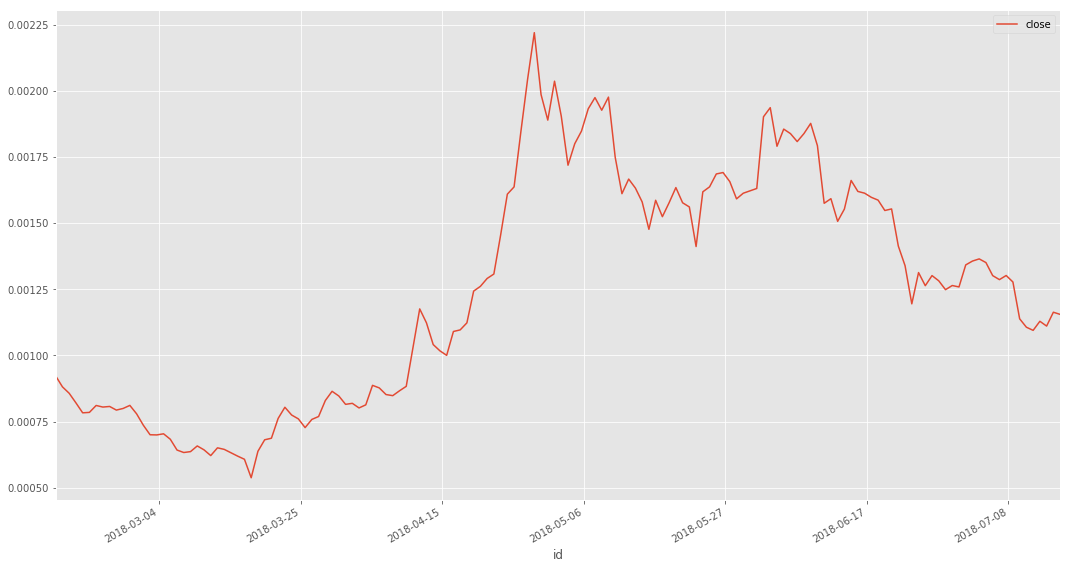

In [6]:
eosbtc_1d_df = kline_plot('eosbtc', '1day')
eosbtc_1d_df.head()

In [ ]:
eosbtc_1d_df = kline_plot('eosbtc', '24h')

In [40]:
get_detail('btcusdt')

{'ch': 'market.btcusdt.detail',
 'status': 'ok',
 'tick': {'amount': 17876.096272860777,
  'close': 6373.61,
  'count': 196808,
  'high': 6586.2,
  'id': 12065807349,
  'low': 6270.0,
  'open': 6584.95,
  'version': 12065807349,
  'vol': 113895422.37666602},
 'ts': 1531299638729}

In [56]:
def get_main_detail(df):
    main_df = df[df['symbol-partition'] == 'main']
    main_details = []
    for index, row in main_df.iterrows():
        symbol = row['symbol']
        print(symbol)
        res = get_detail(symbol)
        tick = res['tick']
        tick['symbol'] = symbol
        tick['base-currency'] = row['base-currency']
        main_details.append(tick)
    return pd.DataFrame(main_details)

In [54]:
main_detail_df = get_main_detail(symbol_df)

In [55]:
main_detail_df

,amount,base-currency,close,count,high,id,low,open,symbol,version,vol
0,1.771547e+04,btc,6346.670000,195176,6542.520000,12067771682,6270.000000,6541.970000,btcusdt,12067771682,1.127670e+08
1,4.886641e+05,eos,2.231054,18490,2.378900,12067772843,2.230001,2.329045,eosht,12067772843,1.124622e+06
2,9.047061e+02,dash,69.940930,23068,74.014888,12067775369,67.039172,68.118607,dashht,12067775369,6.347679e+04
3,1.452567e+05,omg,0.015499,7623,0.016312,12067771764,0.014660,0.015653,omgeth,12067771764,2.292634e+03
4,6.621792e+05,xrp,0.142633,6910,0.150379,12067746248,0.137937,0.140050,xrpht,12067746248,9.430826e+04
5,3.656882e+04,bch,692.050000,39196,718.320000,12067769643,681.380000,718.090000,bchusdt,12067769643,2.540399e+07
6,1.246326e+05,iota,0.002223,10719,0.002258,12067776615,0.002171,0.002176,iotaeth,12067776615,2.772598e+02
7,8.876216e+04,steem,0.002983,11955,0.003289,12067785959,0.002800,0.003066,steemeth,12067785959,2.663359e+02
8,8.312415e+02,xmr,0.020056,8364,0.020067,12067780765,0.019067,0.019428,xmrbtc,12067780765,1.617931e+01
9,7.425364e+03,bch,0.109031,13188,0.110714,12067766321,0.108585,0.109848,bchbtc,12067766321,8.098469e+02


# Volumes of symbols for the last 24H

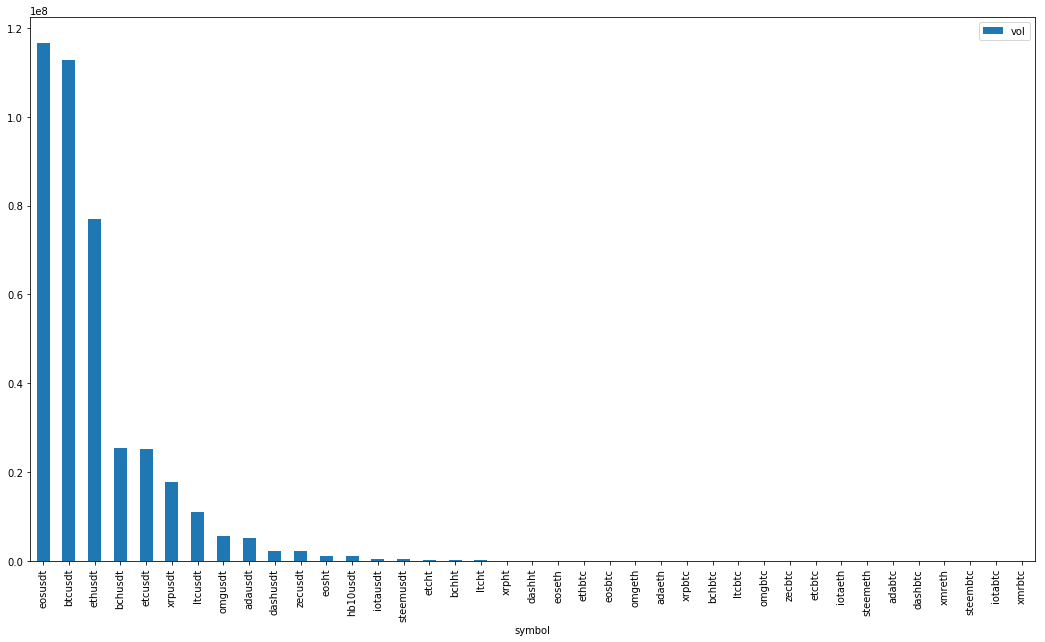

In [71]:
main_detail_df.sort_values(by='vol', ascending=False).plot(figsize=figsize, kind='bar', x='symbol', y='vol')

# Amount of symbols for the last 24H

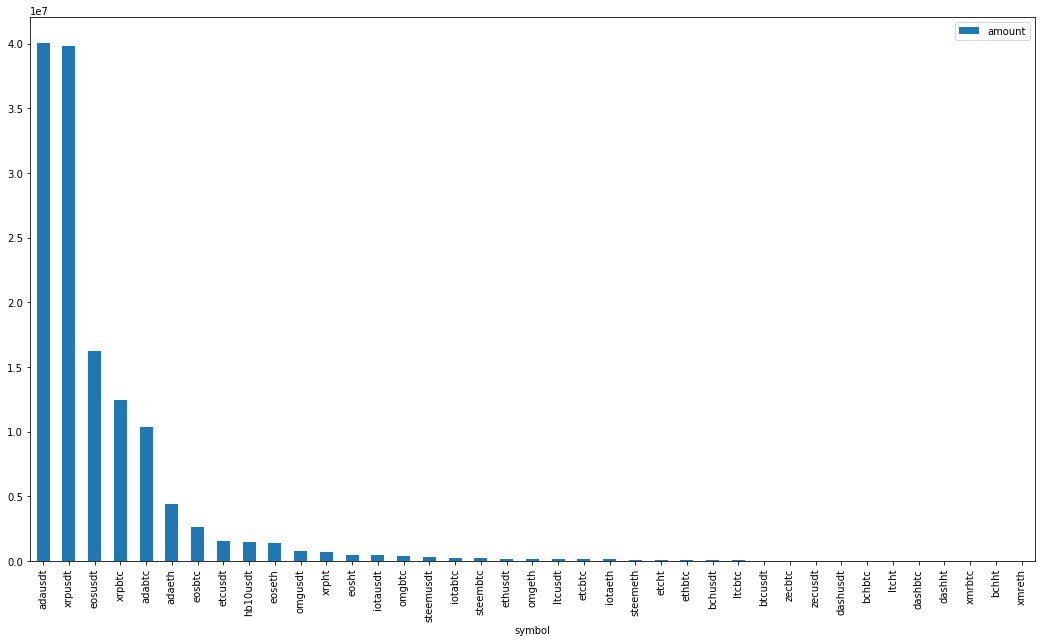

In [72]:
main_detail_df.sort_values(by='amount', ascending=False).plot(figsize=figsize, kind='bar', x='symbol', y='amount')

# Volumes for the last 24H

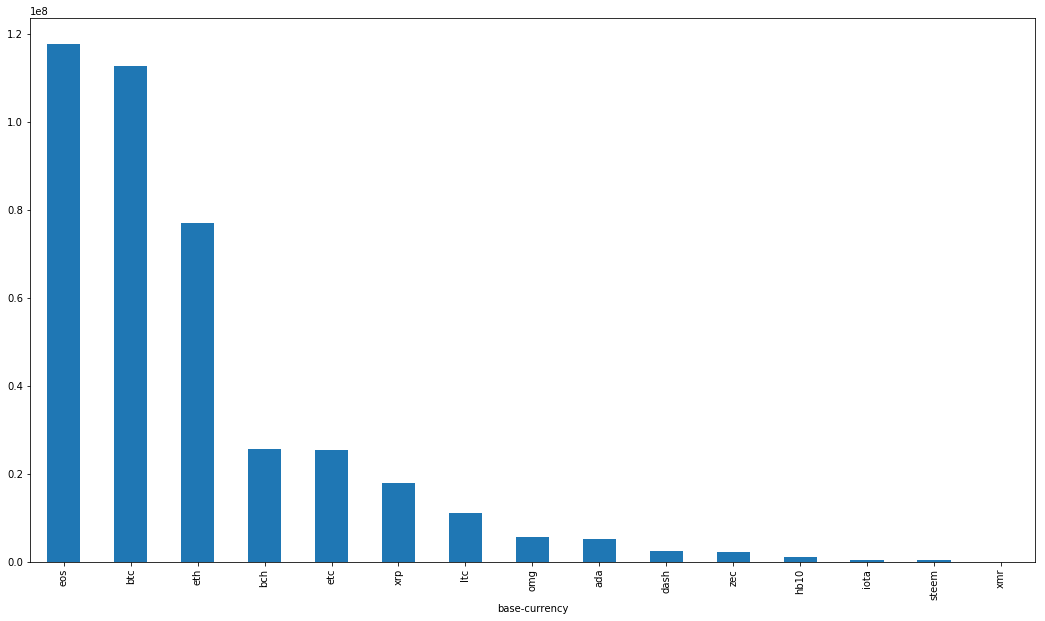

In [67]:
volumes = main_detail_df.groupby(['base-currency'])['vol'].sum()
volumes
volumes.sort_values(ascending=False).plot(figsize=figsize, kind='bar')

In [9]:
import datetime
def toHour(id):
    return datetime.datetime.fromtimestamp(id).hour

In [10]:
buy_fee = 0.002
sell_fee = 0.002

# Day trading strategy
Buy at the hour with min close price, and sell at hour with max close price every single day.

In [7]:
import random

def get_price(open_price, close_price):
    if open_price > close_price:
        return random.uniform(close_price, open_price)
    else:
        return random.uniform(open_price, close_price)

def day_trade_strategy(symbol, size, principle, train_quantil):
    kline = get_kline(symbol, '60min', size)
    df = pd.DataFrame(kline['data'])

    hours = df['id'].apply(toHour)
    df['hour'] = hours
    df.sort_values(by=['id'], inplace=True)
    trainsize = int(size * train_quantil)
    testsize = size - trainsize
    traindf = df.head(trainsize)
    testdf = df.tail(testsize)
    print(len(traindf))
    print(len(testdf))
    hour_grp_close_mean = traindf.groupby(['hour'])['close'].mean()
    print(hour_grp_close_mean)
    buy_hour = hour_grp_close_mean.idxmin()
    sell_hour = hour_grp_close_mean.idxmax()
    first = True
    buy_points = []
    sell_points = []
    fee = 0
    for index, row in testdf.iterrows():
        hour = row['hour']
        price = get_price(row['open'], row['close'])
        if hour == buy_hour:
            buy_points.append(price)
            first = False
        elif hour == sell_hour:
            if first == False:
                sell_points.append(price)
    min_len = min(len(buy_points), len(sell_points))
    buy_points = buy_points[0:min_len-1]
    sell_points = sell_points[0:min_len-1]
    print("Buy point count: {0}, sell point count: {1}".format(len(buy_points), len(sell_points)))
    buy_sell_zip = zip(buy_points, sell_points)
    x = [i for i in range(min_len-1)]
    plt.yscale('linear')
    plt.plot(x, buy_points, 'green')
    plt.plot(x, sell_points, 'red')
    plt.show()
    p = principle
    for pair in list(buy_sell_zip):
        b = pair[0]
        s = pair[1]
        base = round(p * (1 - buy_fee) / b, 4)
        p = s * base * (1-buy_fee)
    roi = round(p/principle, 4)
    return buy_hour, sell_hour, p, roi
    

1800
200
hour
0     7578.434933
1     7574.017867
2     7570.526933
3     7573.114000
4     7566.316000
5     7561.379067
6     7558.487200
7     7558.480000
8     7544.550533
9     7547.403600
10    7545.009467
11    7574.288133
12    7572.219467
13    7568.076400
14    7570.536133
15    7564.652533
16    7567.719867
17    7564.443467
18    7571.169600
19    7566.740800
20    7567.132800
21    7568.580667
22    7568.964933
23    7570.777333
Name: close, dtype: float64
Buy point count: 6, sell point count: 6


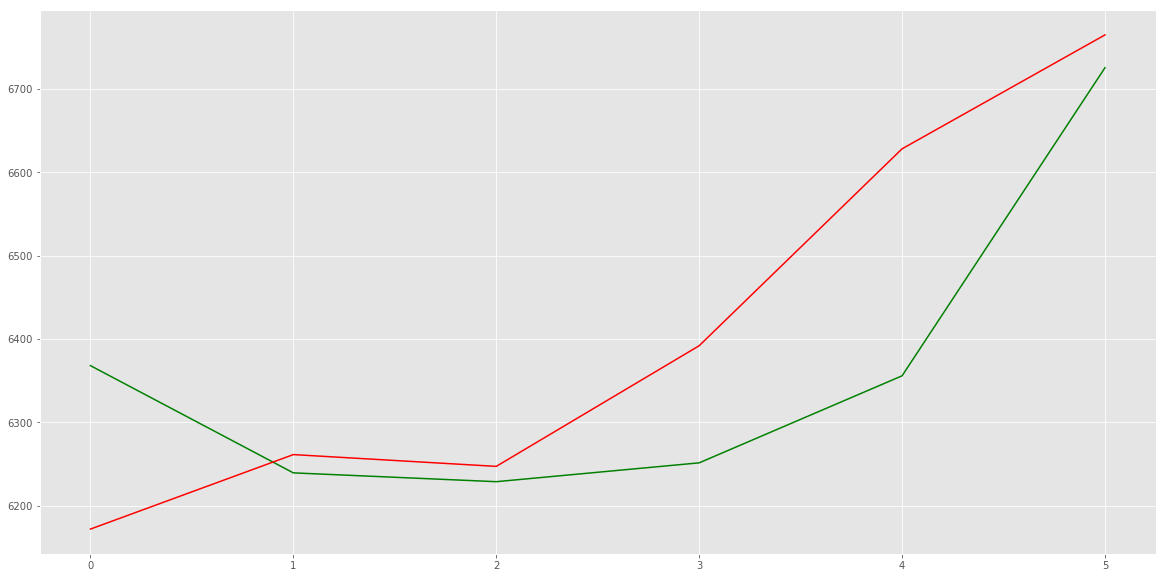

(8, 0, 10213.714892635056, 1.0214000000000001)

In [31]:
day_trade_strategy('btcusdt', 2000, 10000, 0.9)

1400
600
hour
0     13.662064
1     13.656366
2     13.684924
3     13.683990
4     13.645967
5     13.621064
6     13.610429
7     13.643157
8     13.620921
9     13.651438
10    13.644467
11    13.605381
12    13.569024
13    13.501246
14    13.500817
15    13.470798
16    13.495527
17    13.525412
18    13.551646
19    13.635057
20    13.646457
21    13.627507
22    13.644355
23    13.669790
Name: close, dtype: float64
Buy point count: 23, sell point count: 23


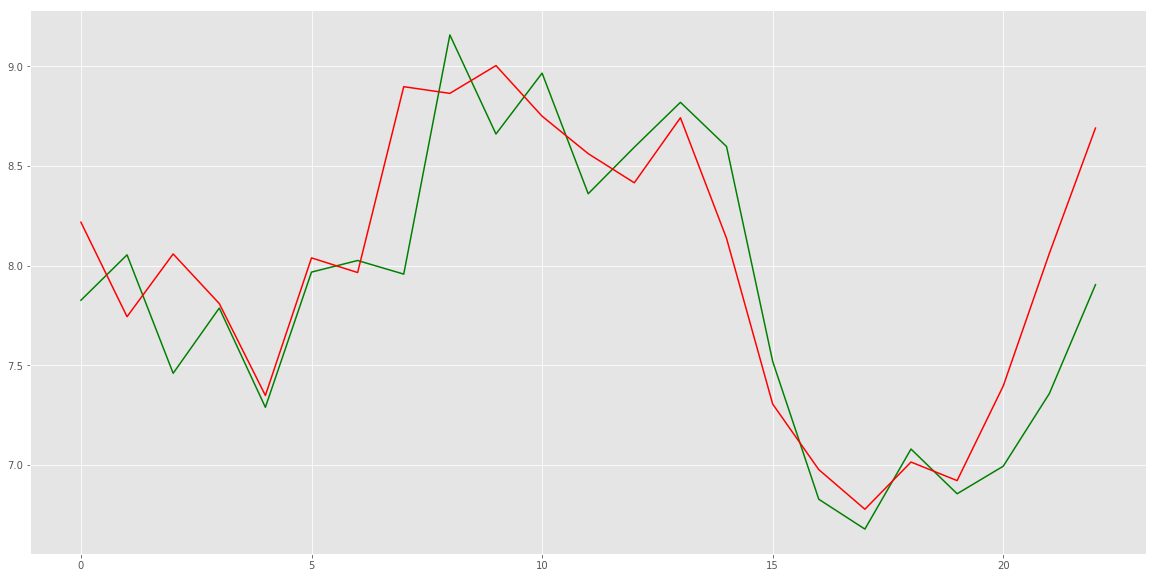

(15, 2, 13356.762133788423, 1.3357000000000001)

In [34]:
day_trade_strategy('eosusdt', 2000, 10000, 0.7)

800
200
hour
0     0.001440
1     0.001441
2     0.001445
3     0.001456
4     0.001456
5     0.001457
6     0.001451
7     0.001452
8     0.001448
9     0.001448
10    0.001449
11    0.001450
12    0.001447
13    0.001445
14    0.001444
15    0.001441
16    0.001442
17    0.001443
18    0.001443
19    0.001444
20    0.001440
21    0.001438
22    0.001437
23    0.001440
Name: close, dtype: float64
Buy point count: 7, sell point count: 7


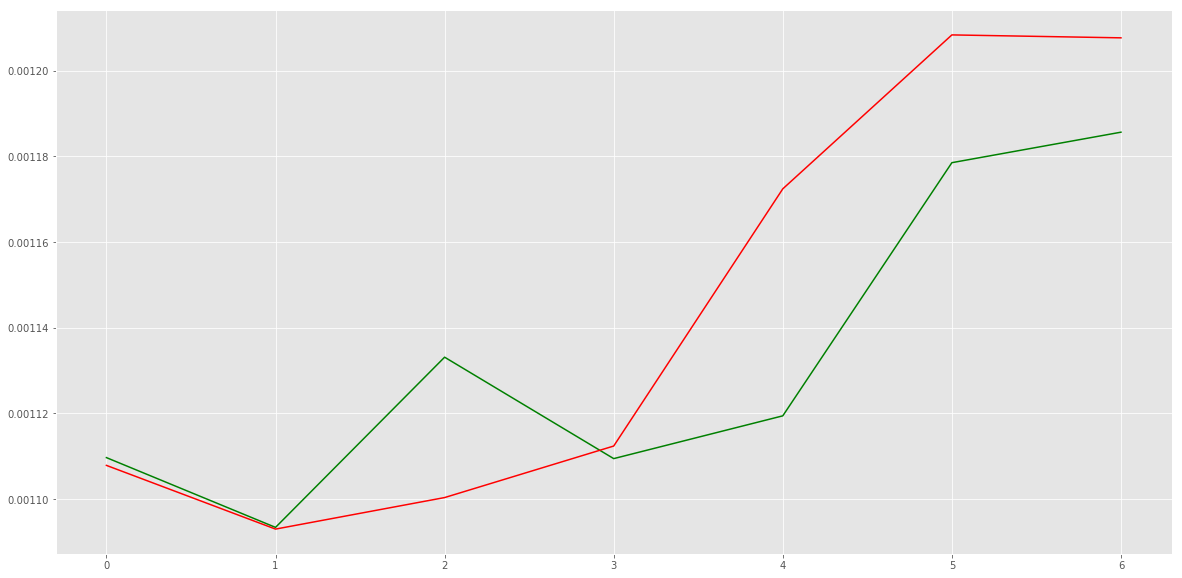

(22, 5, 10334.618838554461, 1.0335000000000001)

In [14]:
day_trade_strategy('eosbtc', 1000, 10000, 0.8)

350
150
hour
0     0.002594
1     0.002593
2     0.002591
3     0.002591
4     0.002592
5     0.002593
6     0.002595
7     0.002597
8     0.002604
9     0.002600
10    0.002602
11    0.002603
12    0.002596
13    0.002594
14    0.002591
15    0.002597
16    0.002599
17    0.002599
18    0.002598
19    0.002603
20    0.002610
21    0.002605
22    0.002603
23    0.002597
Name: close, dtype: float64
Buy point count: 5, sell point count: 5


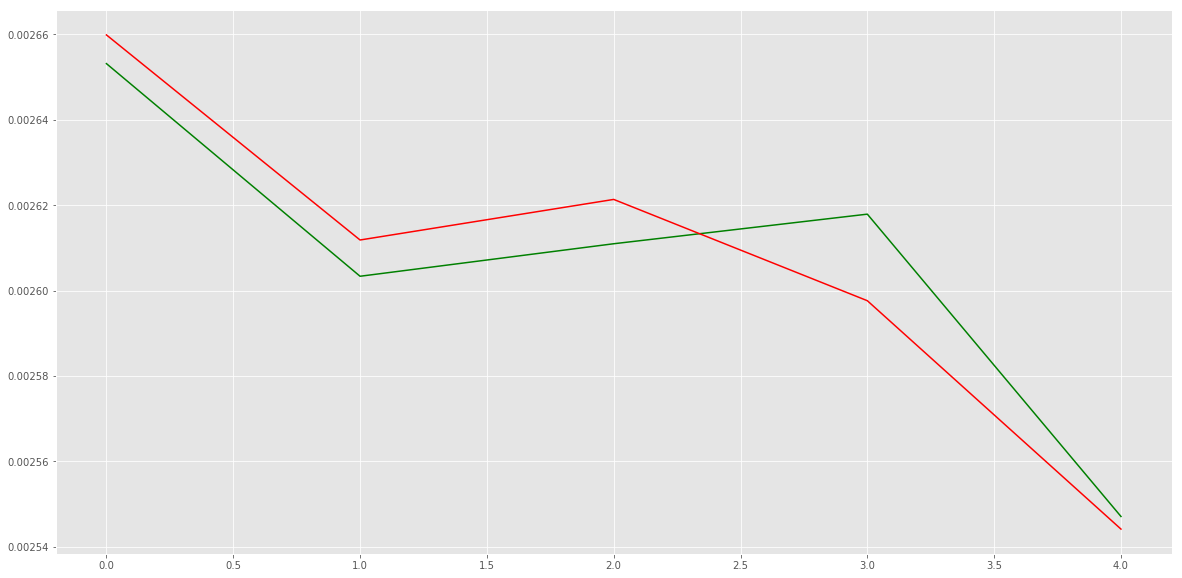

(14, 20, 9809.8279565278845, 0.98099999999999998)

In [15]:
day_trade_strategy('etcbtc', 500, 10000, 0.7)

1400
600
hour
0     0.000030
1     0.000030
2     0.000030
3     0.000030
4     0.000030
5     0.000030
6     0.000030
7     0.000029
8     0.000029
9     0.000029
10    0.000029
11    0.000029
12    0.000029
13    0.000029
14    0.000029
15    0.000029
16    0.000029
17    0.000029
18    0.000029
19    0.000029
20    0.000030
21    0.000029
22    0.000030
23    0.000030
Name: close, dtype: float64
Buy point count: 23, sell point count: 23


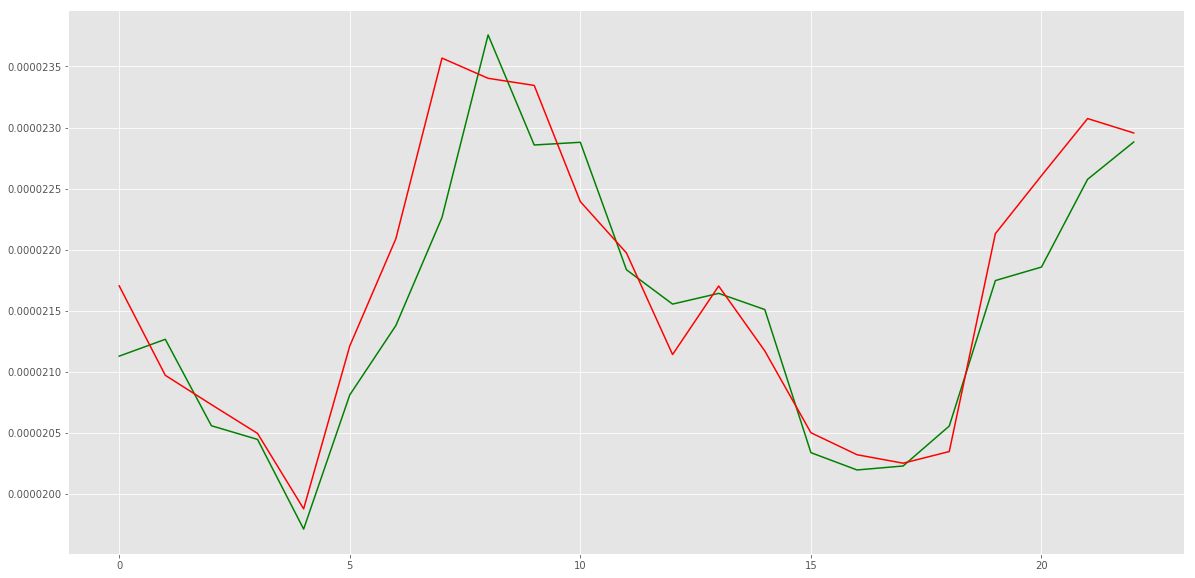

(16, 3, 10925.705791861154, 1.0926)

In [16]:
day_trade_strategy('adabtc', 2000, 10000, 0.7)

1400
600
hour
0     0.000376
1     0.000377
2     0.000377
3     0.000377
4     0.000376
5     0.000376
6     0.000376
7     0.000375
8     0.000374
9     0.000373
10    0.000373
11    0.000374
12    0.000373
13    0.000373
14    0.000373
15    0.000373
16    0.000373
17    0.000373
18    0.000373
19    0.000374
20    0.000375
21    0.000375
22    0.000375
23    0.000376
Name: close, dtype: float64
Buy point count: 23, sell point count: 23


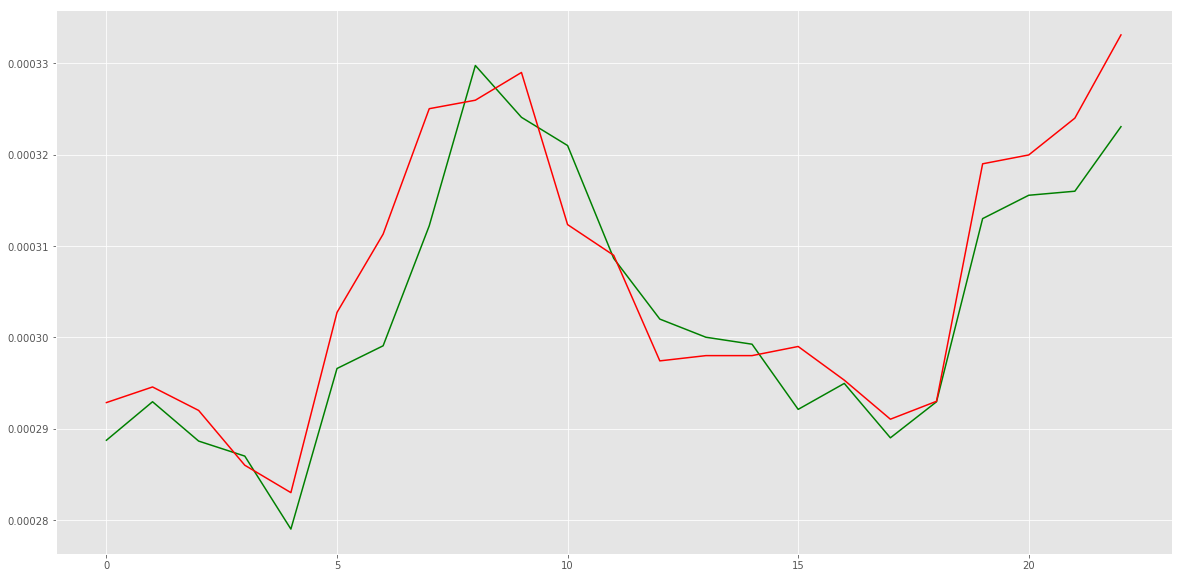

(16, 2, 11296.561273547914, 1.1296999999999999)

In [17]:
day_trade_strategy('adaeth', 2000, 10000, 0.7)

1400
600
hour
0     0.021763
1     0.021796
2     0.021843
3     0.021830
4     0.021821
5     0.021799
6     0.021763
7     0.021789
8     0.021784
9     0.021784
10    0.021771
11    0.021728
12    0.021657
13    0.021585
14    0.021578
15    0.021583
16    0.021613
17    0.021661
18    0.021674
19    0.021735
20    0.021718
21    0.021736
22    0.021765
23    0.021802
Name: close, dtype: float64
Buy point count: 23, sell point count: 23


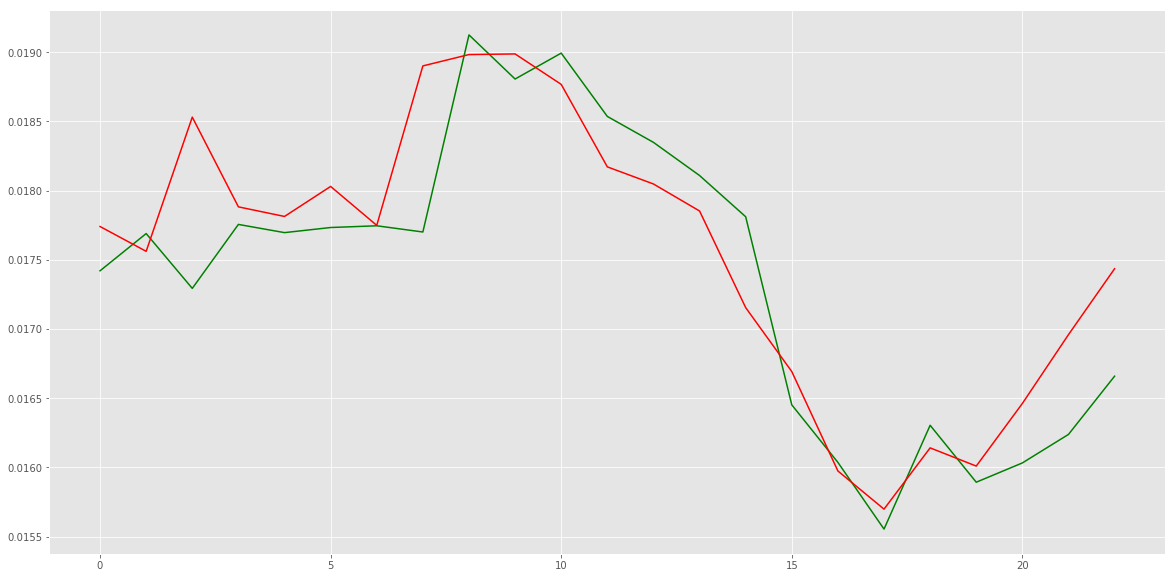

(14, 2, 11257.933214325358, 1.1257999999999999)

In [18]:
day_trade_strategy('eoseth', 2000, 10000, 0.7)

700
300
hour
0     253.021724
1     253.438966
2     253.833793
3     255.039333
4     254.484667
5     254.249667
6     254.785333
7     255.143793
8     254.633793
9     254.822069
10    254.955172
11    254.985172
12    254.511724
13    254.390000
14    254.333103
15    253.168966
16    253.714828
17    253.490000
18    253.810000
19    253.561034
20    252.728276
21    252.714138
22    252.814828
23    252.449655
Name: close, dtype: float64
Buy point count: 11, sell point count: 11


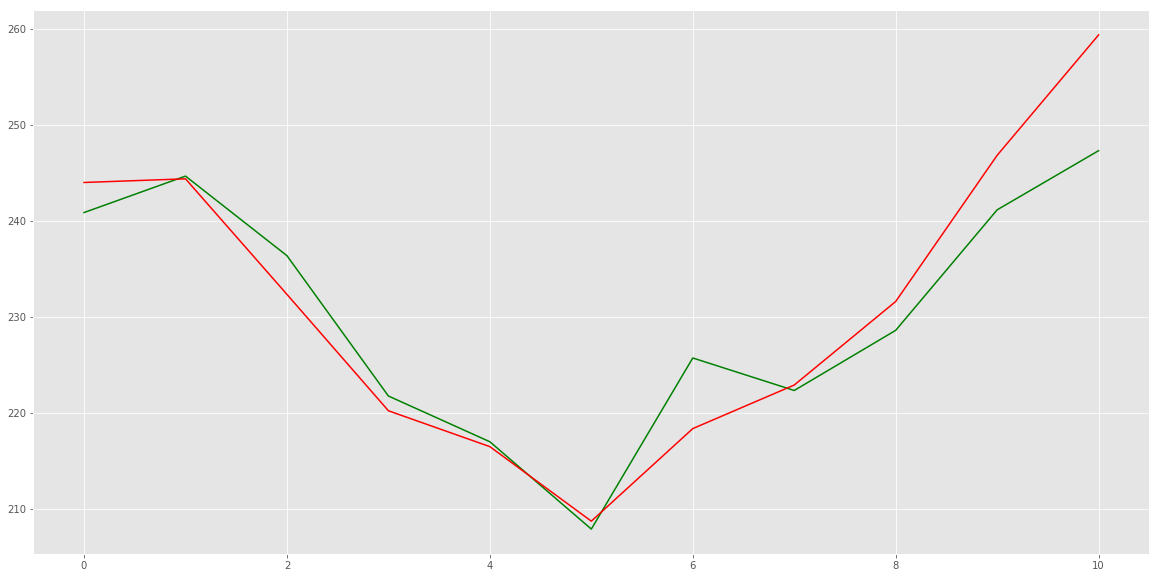

(23, 7, 9985.3740947313272, 0.99850000000000005)

In [20]:
day_trade_strategy('dashusdt', 1000, 10000, 0.7)

175
75
hour
0     0.035210
1     0.035061
2     0.035102
3     0.035066
4     0.035045
5     0.034955
6     0.034985
7     0.034946
8     0.034949
9     0.034871
10    0.034777
11    0.035333
12    0.035056
13    0.035054
14    0.035215
15    0.035102
16    0.034982
17    0.035043
18    0.035203
19    0.035177
20    0.035052
21    0.035038
22    0.035039
23    0.035097
Name: close, dtype: float64
Buy point count: 2, sell point count: 2


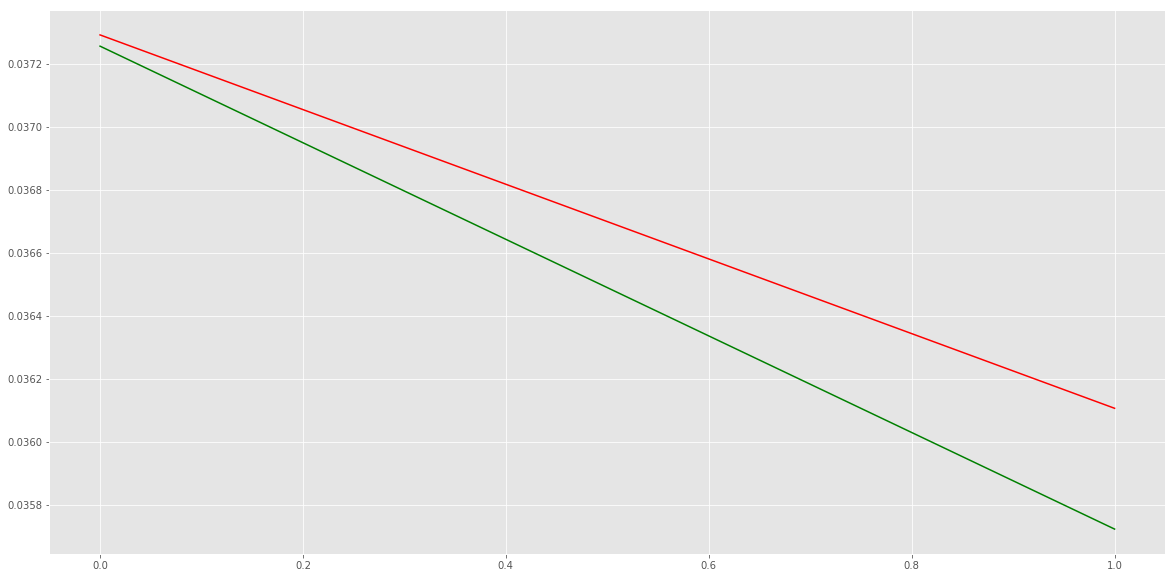

(10, 11, 10036.301772437895, 1.0036)

In [21]:
day_trade_strategy('dashbtc', 250, 10000, 0.7)

# AR

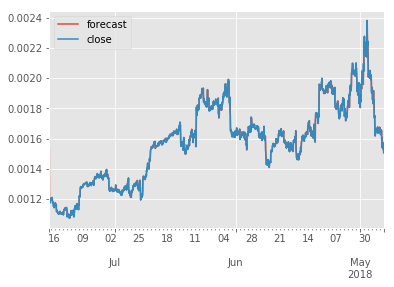

In [65]:
from statsmodels.tsa.arima_model import ARMA

# Forecast the first AR(1) model
close_price = eosbtc_df['close']
mod = ARMA(close_price, order=(1,0))
res = mod.fit()
res.plot_predict(start=close_price.index[0], end=close_price.index[1999])
plt.show()

In [61]:
close_price.index[1991]

Timestamp('2018-04-25 09:00:00')

In [16]:
eosbtc_df = get_kline_df('eosbtc', '60min', 2000)
eosbtc_df

,amount,close,count,high,low,open,vol
id,,,,,,,
2018-07-17 08:00:00,3361.150000,0.001184,21,0.001184,0.001183,0.001184,3.979045
2018-07-17 07:00:00,91712.770000,0.001183,647,0.001187,0.001181,0.001182,108.622147
2018-07-17 06:00:00,97689.130000,0.001182,613,0.001185,0.001174,0.001175,115.155753
2018-07-17 05:00:00,93146.243739,0.001175,1066,0.001189,0.001174,0.001187,109.945726
2018-07-17 04:00:00,102496.480382,0.001188,1220,0.001205,0.001186,0.001199,122.763590
2018-07-17 03:00:00,46950.494658,0.001199,1022,0.001206,0.001196,0.001197,56.406353
2018-07-17 02:00:00,108396.360000,0.001196,1001,0.001197,0.001190,0.001191,129.204173
2018-07-17 01:00:00,73502.144575,0.001190,651,0.001198,0.001189,0.001196,87.778303
2018-07-17 00:00:00,93494.104882,0.001195,1118,0.001204,0.001189,0.001204,111.602168


# Greedy strategy
buy: when low enough
1. last x days/hours/mins
2. slope >= y1
3. profit <= -0.2%
4. looks like a concave function

sell: when high enough

1. last x days/hours/mins
2. slope >= y2
3. profit >= 3%
4. looks like a convex function

In [67]:
eosbtc_df.sort_index(inplace=True)   
eosbtc_df.head()

,amount,close,count,high,low,open,vol
id,,,,,,,
2018-04-25 01:00:00,245748.652234,0.001575,5189,0.001579,0.001519,0.001554,379.124263
2018-04-25 02:00:00,158921.981572,0.001550,3702,0.001606,0.001546,0.001575,252.143001
2018-04-25 03:00:00,124459.392507,0.001508,3368,0.001566,0.001501,0.001545,191.410337
2018-04-25 04:00:00,288042.478594,0.001507,7010,0.001544,0.001455,0.001506,431.128630
2018-04-25 05:00:00,133997.673054,0.001524,3920,0.001542,0.001483,0.001507,203.366661


In [ ]:
def buy(df, index, look_back_prices, slope, profit):
    row = df.loc[index]
    _slope = (look_back_prices[0]-look_back_prices[-1]) / (len(look_back_prices))
    

In [95]:
2000 >> 1

1000

5.893523285866452